https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

# Univariate time series forecast with LSTM

In [1]:
# univariate data preparation
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import pandas as pd
import numpy as np
import myLibrary as mL
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
STATION_ID = "42036"    # 33.61% NaN values -> Best value for GOM and 2022
YEAR = "2022"
n=1
lag=1
num_test_records=7*24

In [3]:
data = mL.get_buoy_data(STATION_ID, YEAR)

data = data.drop([
    "WDIR_42036",
    "WSPD_42036",
    "WVHT_42036",
    "APD_42036",
    "MWD_42036",
    "PRES_42036",
    "ATMP_42036",
    #"WTMP_42036",
    "DEWP_42036"], axis=1)

from disc


In [4]:
print("NaN values: ", data.isna().sum().sum())
data.fillna(method='ffill', inplace=True) #ffill .. forward fill (just copy previous value)
print("Remaining NaN values: ", data.isna().sum().sum())
# msno.matrix(data)

NaN values:  57
Remaining NaN values:  0


In [5]:
print(type(data))
data

<class 'pandas.core.frame.DataFrame'>


,WTMP_42036
timestamp,
2022-01-01 00:00:00,23.0
2022-01-01 01:00:00,23.0
2022-01-01 02:00:00,23.0
2022-01-01 03:00:00,23.0
2022-01-01 04:00:00,23.0
...,...
2022-12-31 19:00:00,22.0
2022-12-31 20:00:00,22.0
2022-12-31 21:00:00,22.1


# Preprocessing

### Transform Time Series to Stationary
Preprocessing step that converts the absolute values to delta values. This should result in a more skillful forecast.

In [6]:
# value_stationary(t=i) = value(t=i) - value(t=i-1)
# first value is removed, since value(t=0-1) does not exist
def data_to_stationary(data):
    data_stationary = pd.DataFrame()
    #Transform time series to stationary. = Preprocessing step that converts the absolute values to delta values.
    data_stationary[f"WTMP_{STATION_ID}"] =  data[f"WTMP_{STATION_ID}"] - data[f"WTMP_{STATION_ID}"].shift(n)    # y = value(i) - value(i-n)
    data_stationary = data_stationary.iloc[n:] # remove first n entries since there is no delta value for them
    return data_stationary

data_stationary = data_to_stationary(data)
data_stationary


,WTMP_42036
timestamp,
2022-01-01 01:00:00,0.0
2022-01-01 02:00:00,0.0
2022-01-01 03:00:00,0.0
2022-01-01 04:00:00,0.0
2022-01-01 05:00:00,0.0
...,...
2022-12-31 19:00:00,0.0
2022-12-31 20:00:00,0.0
2022-12-31 21:00:00,0.1


### Provide input X and output y.
LSTM model expects data divided into input (X) and output (y). The model learns a function that maps an input X to an output y. In this example, X is the observation at timestep t-lag and y is the value at t.

In [7]:
#X represents the value at t-1 and y the value at t
def data_to_supervised(data, lag):
    data_supervised = pd.DataFrame()
    #LSTM model expects data devided into input (X) and output (y). The model learns a function that maps an input X to an output y. In this example, X is the observation at timestep t-1 and y is the value at t.
    data_supervised["X"] = data[f"WTMP_{STATION_ID}"].shift(lag)
    data_supervised["y"] = data[f"WTMP_{STATION_ID}"]
    data_supervised = data_supervised.iloc[lag:] # remove first lag entries since there is no valid value in y
    return data_supervised

data_supervised = data_to_supervised(data_stationary, 1)
data_supervised

,X,y
timestamp,,
2022-01-01 02:00:00,0.0,0.0
2022-01-01 03:00:00,0.0,0.0
2022-01-01 04:00:00,0.0,0.0
2022-01-01 05:00:00,0.0,0.0
2022-01-01 06:00:00,0.0,-0.1
...,...,...
2022-12-31 19:00:00,0.1,0.0
2022-12-31 20:00:00,0.0,0.0
2022-12-31 21:00:00,0.0,0.1


### Train Test Split

In [8]:
def train_test_split(data, num_test_records):
    train, test = data[0:-num_test_records], data[-num_test_records:]
    return train, test

train, test = train_test_split(data_supervised, num_test_records)
train

,X,y
timestamp,,
2022-01-01 02:00:00,0.0,0.0
2022-01-01 03:00:00,0.0,0.0
2022-01-01 04:00:00,0.0,0.0
2022-01-01 05:00:00,0.0,0.0
2022-01-01 06:00:00,0.0,-0.1
...,...,...
2022-12-24 19:00:00,-0.1,0.0
2022-12-24 20:00:00,0.0,0.1
2022-12-24 21:00:00,0.1,-0.1


In [9]:
test

,X,y
timestamp,,
2022-12-25 00:00:00,-0.1,0.1
2022-12-25 01:00:00,0.1,0.0
2022-12-25 02:00:00,0.0,-0.1
2022-12-25 03:00:00,-0.1,0.0
2022-12-25 04:00:00,0.0,-0.1
...,...,...
2022-12-31 19:00:00,0.1,0.0
2022-12-31 20:00:00,0.0,0.0
2022-12-31 21:00:00,0.0,0.1


### Normalize the data
   The default activation function for LSTMs is the hyperbolic tangent (tanh) which outputs values between -1 and 1. We use MinMaxScaler class to reshape out data to this scale. To make the experiment fair, we only consider the training data for the min and max values. Otherwise, we would contaminate the experiment with knowledge from the test data.

In [10]:
scaler = None
def scale(train, test):
    # fit scaler
    global scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_col = train["X"].values.reshape(-1, 1)
    scaler = scaler.fit(train_col)

    # transform train
    train_scaled = pd.DataFrame()
    train_scaled["X"] = pd.Series(scaler.transform(train[["X"]]).squeeze())
    train_scaled["y"] = pd.Series(scaler.transform(train[["y"]]).squeeze())

    # transform test
    test_scaled = pd.DataFrame()
    test_scaled["X"] = pd.Series(scaler.transform(test[["X"]]).squeeze())
    test_scaled["y"] = pd.Series(scaler.transform(test[["y"]]).squeeze())

    return train_scaled, test_scaled

In [11]:
#invert single float value
def invert_scale(value):
    scaled_value_array = np.array([[value, 0]])
    inverted_value = scaler.inverse_transform(scaled_value_array)[0][0]
    return inverted_value

In [12]:
train_scaled, test_scaled = scale(train, test)

/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Master_Project/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [13]:
train_scaled

,X,y
0,0.04,0.04
1,0.04,0.04
2,0.04,0.04
3,0.04,0.04
4,0.04,-0.04
...,...,...
8585,-0.04,0.04
8586,0.04,0.12
8587,0.12,-0.04
8588,-0.04,0.04


In [14]:
test_scaled

,X,y
0,-0.04,0.12
1,0.12,0.04
2,0.04,-0.04
3,-0.04,0.04
4,0.04,-0.04
...,...,...
163,0.12,0.04
164,0.04,0.04
165,0.04,0.12
166,0.12,0.12


In [15]:
#TEST SCALING
# train_compare = train_scaled.applymap(invert_scale)

# test = pd.DataFrame()
# test["original"] = train["X"].values
# test["scale_test"] = train_compare["X"]
# test['equals'] = np.isclose(test['original'], test['scale_test'], rtol=1e-5, atol=1e-5)

# print("All values correctly converted back:", np.isclose(train["X"], train_compare["X"], rtol=1e-5, atol=1e-5).all())
# test

### LSTM Model

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

Samples: independent observations i.e. rows of data
Time steps: ???
Features: number of features (in this case 1)

In [34]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    train = train.values    #convert dataframe to numpy array
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')   #SGD instead of adam ... SGD is a more simple optimizer which can help avoiding overfitting
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)  #What exactly is the epochs parameter here?
        model.reset_states()
    return model

In [17]:
# make a one-step forecast
# This function helps with reshaping.
def forecast_lstm(model, batch_size, X):
    X = np.array([X])
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]

In [18]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 200, 50)    #training data, batch size, epochs, #neurons
#lstm_model = fit_lstm(train_scaled, 1, 2, 5)    #training data, batch size, epochs, #neurons

2023-04-17 20:38:07.542311: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [19]:
# Forecast the entire training dataset to build up state for forecasting
def build_up_state():
    #Reset state
    lstm_model.reset_states()
    # extract input values from test_scaled
    X_train = train_scaled['X'].values
    # reshape input values for LSTM model input
    X_train = X_train.reshape(X_train.shape[0], 1, 1)
    # forecast the entire training dataset to build up state for forecasting
    lstm_model.predict(X_train, batch_size=1)

# One-Shot forecast

In [20]:
build_up_state()

8590/8590 [==============================] - 3s 321us/step


In [21]:
prediction_1 = pd.DataFrame()
prediction_1["X_scaled"] = test_scaled["X"]   # Input to Model    #Basically not realy needed here
prediction_1["y_scaled"] = test_scaled["y"]   # Ground Truth
prediction_1["True_Temp"] = data["WTMP_42036"].tail(prediction_1.shape[0]).values

prediction_1["X_dif"] = test["X"].values
prediction_1["y_dif"] = test["y"].values  #difference to previous

prediction_1["yhat_raw"] = 0 # raw prediction, comparable to y_Scaled
prediction_1["yhat_dif"] = 0# predicted difference to previous observation, comparable to y_dif
prediction_1["yhat_true_temp"] =  0# final prediction, comparable to True_Temp

prediction_1

,X_scaled,y_scaled,True_Temp,X_dif,y_dif,yhat_raw,yhat_dif,yhat_true_temp
0,-0.04,0.12,22.2,-0.1,0.1,0,0,0
1,0.12,0.04,22.2,0.1,0.0,0,0,0
2,0.04,-0.04,22.1,0.0,-0.1,0,0,0
3,-0.04,0.04,22.1,-0.1,0.0,0,0,0
4,0.04,-0.04,22.0,0.0,-0.1,0,0,0
...,...,...,...,...,...,...,...,...
163,0.12,0.04,22.0,0.1,0.0,0,0,0
164,0.04,0.04,22.0,0.0,0.0,0,0,0
165,0.04,0.12,22.1,0.0,0.1,0,0,0
166,0.12,0.12,22.2,0.1,0.1,0,0,0


In [22]:
for index, row in prediction_1.iterrows():
    # make one-step forecast
    yhat = forecast_lstm(lstm_model, 1, row["X_scaled"])  #yhat = predicted y
    prediction_1.at[index, "yhat_raw"] = yhat

    # invert scaling
    yhat = invert_scale(yhat)
    prediction_1.at[index, "yhat_dif"] = yhat

    # invert differencing
    prev_absolute_observation = data["WTMP_42036"][-len(test_scaled)+index-1]
    yhat = prev_absolute_observation + yhat  #add the delta value (=yhat) to the according absolute value
    prediction_1.at[index, "yhat_true_temp"] = yhat


prediction_1

,X_scaled,y_scaled,True_Temp,X_dif,y_dif,yhat_raw,yhat_dif,yhat_true_temp
0,-0.04,0.12,22.2,-0.1,0.1,0.027425,-0.015719,22.084281
1,0.12,0.04,22.2,0.1,0.0,0.028382,-0.014522,22.185478
2,0.04,-0.04,22.1,0.0,-0.1,0.027561,-0.015549,22.184451
3,-0.04,0.04,22.1,-0.1,0.0,0.026324,-0.017095,22.082905
4,0.04,-0.04,22.0,0.0,-0.1,0.026554,-0.016807,22.083193
...,...,...,...,...,...,...,...,...
163,0.12,0.04,22.0,0.1,0.0,0.015623,-0.030471,21.969529
164,0.04,0.04,22.0,0.0,0.0,0.014930,-0.031338,21.968662
165,0.04,0.12,22.1,0.0,0.1,0.014464,-0.031920,21.968080
166,0.12,0.12,22.2,0.1,0.1,0.014507,-0.031866,22.068134


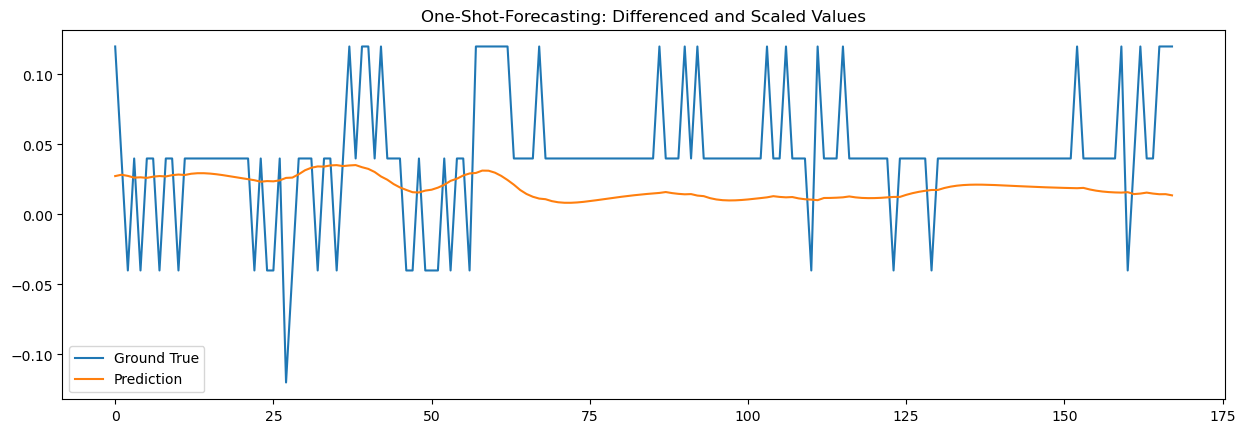

In [23]:
plt.figure().set_figwidth(15)
plt.plot(prediction_1["y_scaled"], label="Ground True")
plt.plot(prediction_1["yhat_raw"], label="Prediction")
plt.title("One-Shot-Forecasting: Differenced and Scaled Values")
plt.legend()
plt.show()

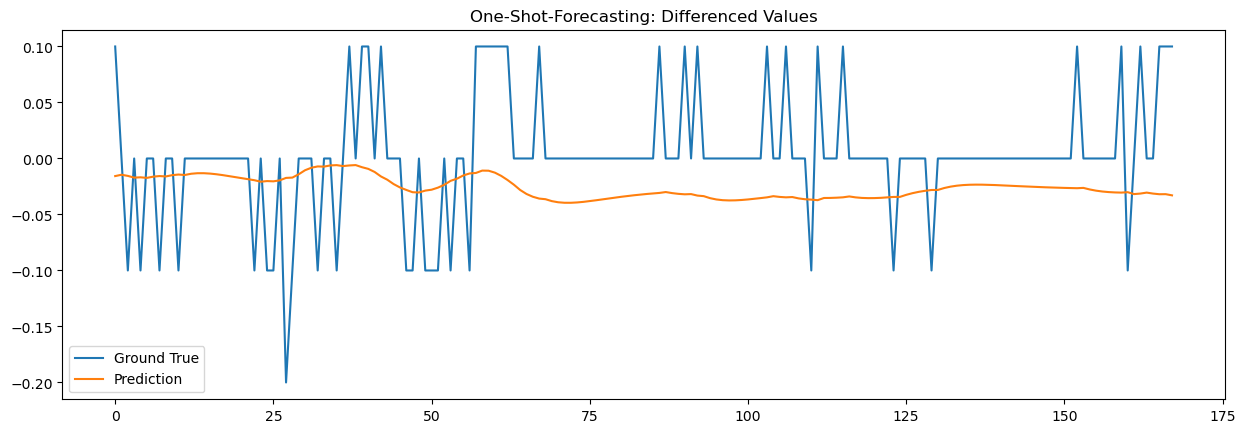

In [24]:
plt.figure().set_figwidth(15)
plt.plot(prediction_1["y_dif"], label="Ground True")
plt.plot(prediction_1["yhat_dif"], label="Prediction")
plt.title("One-Shot-Forecasting: Differenced Values")
plt.legend()
plt.show()

Shape is pretty similar ... indicates that there is no error in converting the values!

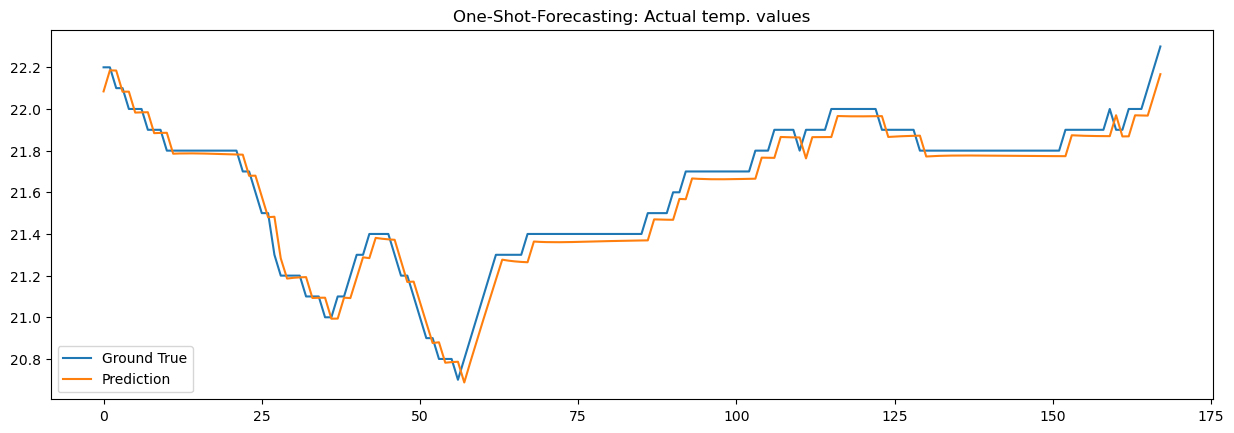

In [25]:
plt.figure().set_figwidth(15)
plt.plot(prediction_1["True_Temp"], label="Ground True")
plt.plot(prediction_1["yhat_true_temp"], label="Prediction")
plt.title("One-Shot-Forecasting: Actual temp. values")
plt.legend()
plt.show()

# Ask Austin:
## It still seems like there is a time-shift - it seems like the prediction is not correctly converted back to real temperature values. Anyways, I can not find the root of this problem.

## Furthermore, according to my understanding the error where the ground-truth is constant should be the constant.

# EXPLANATION: THE LSTM MODEL IS NOT STATEFULL!!

# TODO: Read description of tutorial - especially part about what I have in build_up_state()


In [26]:
# report performance
mae = mean_absolute_error(prediction_1["True_Temp"], prediction_1["yhat_true_temp"])
mse = mean_squared_error(prediction_1["True_Temp"], prediction_1["yhat_true_temp"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.04880332723509436
MSE:  0.0038547516121859434


# Doublechecked everything until here!

# 2-Week forecast


In [27]:
# RESET
build_up_state()

8590/8590 [==============================] - 3s 340us/step


In [28]:
prediction_2 = pd.DataFrame()
prediction_2["X_scaled"] = test_scaled["X"]   # Input to Model    #Basically not realy needed here
prediction_2["y_scaled"] = test_scaled["y"]   # Ground Truth
prediction_2["True_Temp"] = data["WTMP_42036"].tail(prediction_2.shape[0]).values

prediction_2["X_dif"] = test["X"].values
prediction_2["y_dif"] = test["y"].values  #difference to previous

prediction_2["yhat_raw"] = 0  # raw prediction, comparable to y_Scaled
prediction_2["yhat_dif"] = 0  # predicted difference to previous observation, comparable to y_dif
prediction_2["yhat_true_temp"] =  0   # final prediction, comparable to True_Temp

prediction_2

,X_scaled,y_scaled,True_Temp,X_dif,y_dif,yhat_raw,yhat_dif,yhat_true_temp
0,-0.04,0.12,22.2,-0.1,0.1,0,0,0
1,0.12,0.04,22.2,0.1,0.0,0,0,0
2,0.04,-0.04,22.1,0.0,-0.1,0,0,0
3,-0.04,0.04,22.1,-0.1,0.0,0,0,0
4,0.04,-0.04,22.0,0.0,-0.1,0,0,0
...,...,...,...,...,...,...,...,...
163,0.12,0.04,22.0,0.1,0.0,0,0,0
164,0.04,0.04,22.0,0.0,0.0,0,0,0
165,0.04,0.12,22.1,0.0,0.1,0,0,0
166,0.12,0.12,22.2,0.1,0.1,0,0,0


In [29]:
prev_obs = data["WTMP_42036"][-num_test_records-1]
#prev_obs_scaled = train_scaled["X"].iloc[-1]    # First X value for prediction
prev_obs_scaled = prediction_2["X_scaled"].iloc[0]    # First X value for prediction

for index, row in prediction_2.iterrows():
    yhat = forecast_lstm(lstm_model, 1, prev_obs_scaled)
    prev_obs_scaled = yhat  #update prev. scaled obs. value
    prediction_2.at[index, "yhat_raw"] = yhat

    # invert scaling
    yhat = invert_scale(yhat)
    prediction_2.at[index, "yhat_dif"] = yhat

    # invert differencing
    yhat = prev_obs + yhat
    prev_obs = yhat     # update prev. observation value
    prediction_2.at[index, "yhat_true_temp"] = yhat

prediction_2

,X_scaled,y_scaled,True_Temp,X_dif,y_dif,yhat_raw,yhat_dif,yhat_true_temp
0,-0.04,0.12,22.2,-0.1,0.1,0.027425,-0.015719,22.084281
1,0.12,0.04,22.2,0.1,0.0,0.027983,-0.015022,22.069259
2,0.04,-0.04,22.1,0.0,-0.1,0.028324,-0.014595,22.054664
3,-0.04,0.04,22.1,-0.1,0.0,0.028487,-0.014392,22.040272
4,0.04,-0.04,22.0,0.0,-0.1,0.028502,-0.014373,22.025900
...,...,...,...,...,...,...,...,...
163,0.12,0.04,22.0,0.1,0.0,0.025432,-0.018210,19.154191
164,0.04,0.04,22.0,0.0,0.0,0.025432,-0.018210,19.135981
165,0.04,0.12,22.1,0.0,0.1,0.025432,-0.018210,19.117771
166,0.12,0.12,22.2,0.1,0.1,0.025432,-0.018210,19.099561


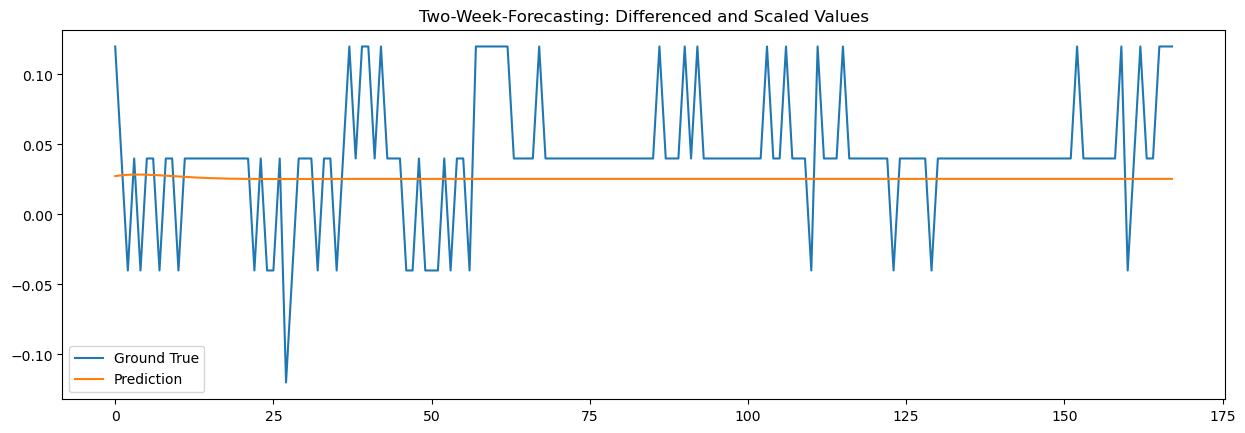

In [30]:
plt.figure().set_figwidth(15)
plt.plot(prediction_2["y_scaled"], label="Ground True")
plt.plot(prediction_2["yhat_raw"], label="Prediction")
plt.title("Two-Week-Forecasting: Differenced and Scaled Values")
plt.legend()
plt.show()

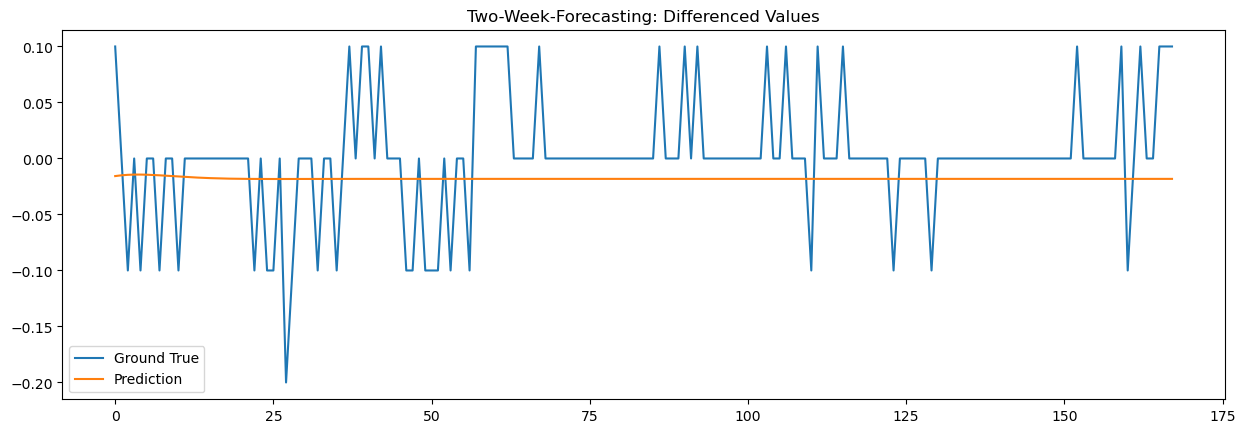

In [31]:
plt.figure().set_figwidth(15)
plt.plot(prediction_2["y_dif"], label="Ground True")
plt.plot(prediction_2["yhat_dif"], label="Prediction")
plt.title("Two-Week-Forecasting: Differenced Values")
plt.legend()
plt.show()

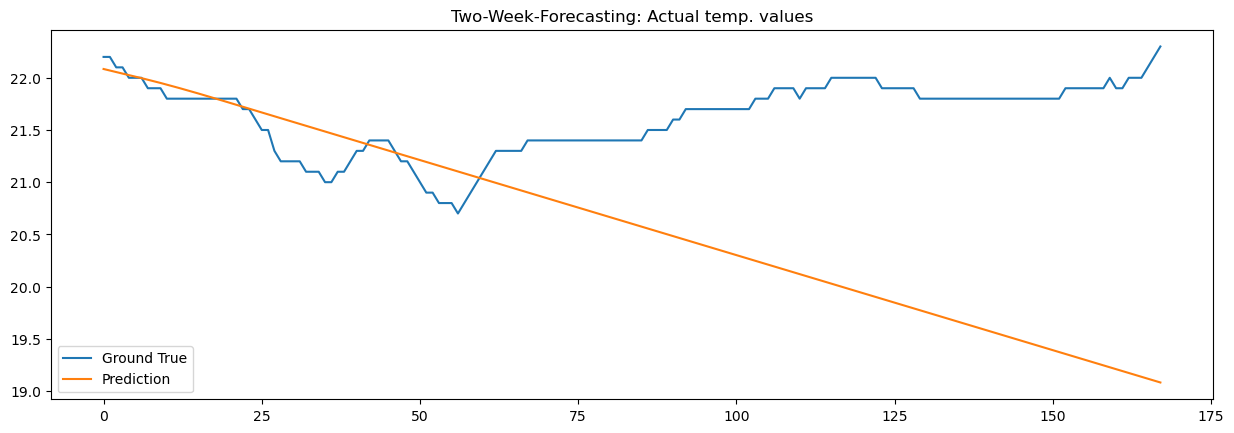

In [32]:
plt.figure().set_figwidth(15)
plt.plot(prediction_2["True_Temp"], label="Ground True")
plt.plot(prediction_2["yhat_true_temp"], label="Prediction")
plt.title("Two-Week-Forecasting: Actual temp. values")
plt.legend()
plt.show()

In [33]:
# report performance
mae = mean_absolute_error(prediction_2["True_Temp"], prediction_2["yhat_true_temp"])
mse = mean_squared_error(prediction_2["True_Temp"], prediction_2["yhat_true_temp"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  1.132945326354312
MSE:  2.201582266646917


# Possible reasons why it looks like a linear regression:

* to little training data
* increase epochs
* Model architecture is too simple
* increase number of hidden units
* Overfitting --> use dropout or regularization to mitigate overfitting
* initialization and random seeds ?? --> keywords for google
*

# Proble is overfitting!
#adding dropout helped a lot, but the shape is still the same!